In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
dataset = xr.open_dataset("tco300_omimls_oct2004_to_dec2024_1by1.nc")
dataset

<xarray.Dataset> Size: 63MB
Dimensions:  (months: 243, y_elements: 180, x_elements: 360)
Dimensions without coordinates: months, y_elements, x_elements
Data variables:
    TropoO3  (months, y_elements, x_elements) float32 63MB ...
Attributes:
    Title:    OMI/MLS Ground-to-300hPa Column Ozone for TOARII, etc.

OMI/MLS Ground-to-300hPa Column Ozone for TOARII *y_elements: latitude, x_elements: longitude, period: October 2004 - December 2024

So now it is time for some data cleaning, there should not be negative values in the data

In [3]:
ozone_data = dataset["TropoO3"]
cleaned_ozone_dataset = ozone_data.where(ozone_data >= 0)
dataset["TropoO3"] = cleaned_ozone_dataset
dataset["TropoO3"]

<xarray.DataArray 'TropoO3' (months: 243, y_elements: 180, x_elements: 360)> Size: 63MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Dimensions without coordinates: months, y_elements, x_elements
Attributes:
    units:      Dobson Units
    name:       Tropo O3 Gnd-to-Tropopause
    latitude:   -89.5, -88.5, ..., 89.5
    longitude:  -179.5, -178.5, ..., 179.5
    Month:      Oct2004, Nov2004, ..., Dec2024

Try to visualize this cleaned data now for arbitrary month

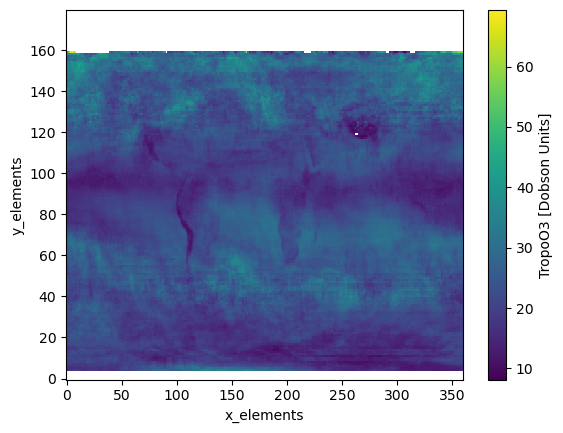

In [4]:
# Visualize arbitrary month
dataset.TropoO3[181].plot()

In [5]:
# create separate datetime64 object, just so we can group ozone by month 

start_date = '2005-01-01'
end_date = '2024-12-31'
total_months_available = len(dataset.months)

time_coords = pd.date_range(start=start_date, periods=total_months_available, freq='MS')

ozone = dataset['TropoO3']

total_na = ozone.isnull().sum()
ozone = ozone.assign_coords(time=('months', time_coords))
monthly_mean = ozone.groupby('time.month').mean('months')

In [6]:
print(total_months_available)

243


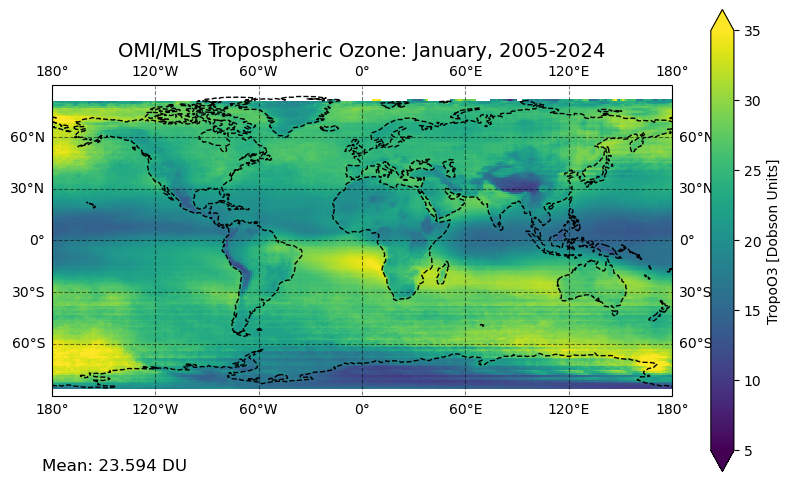

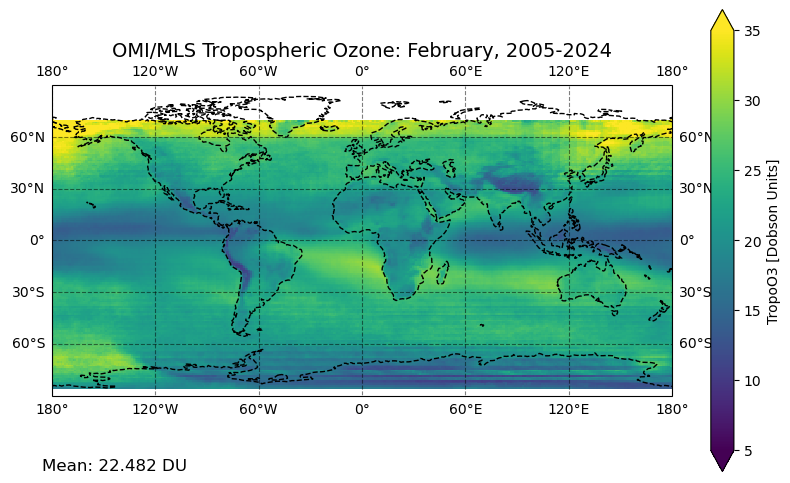

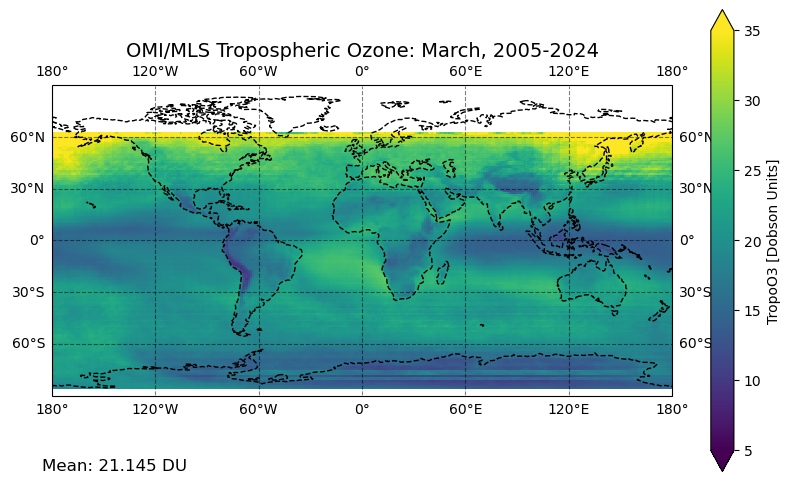

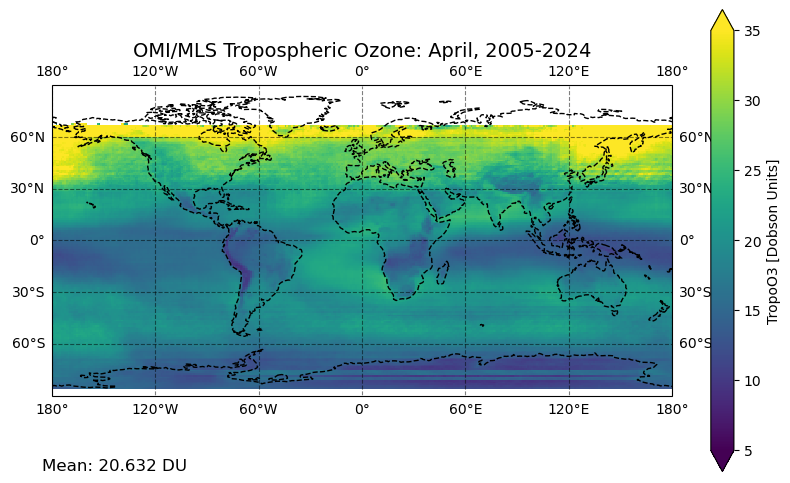

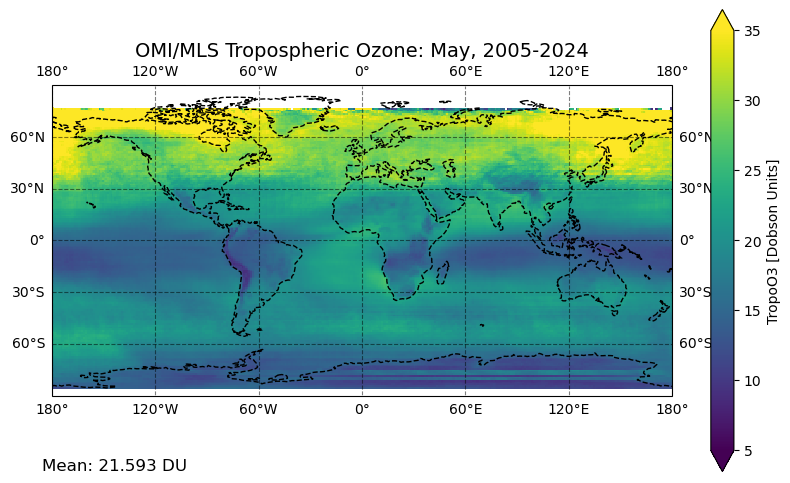

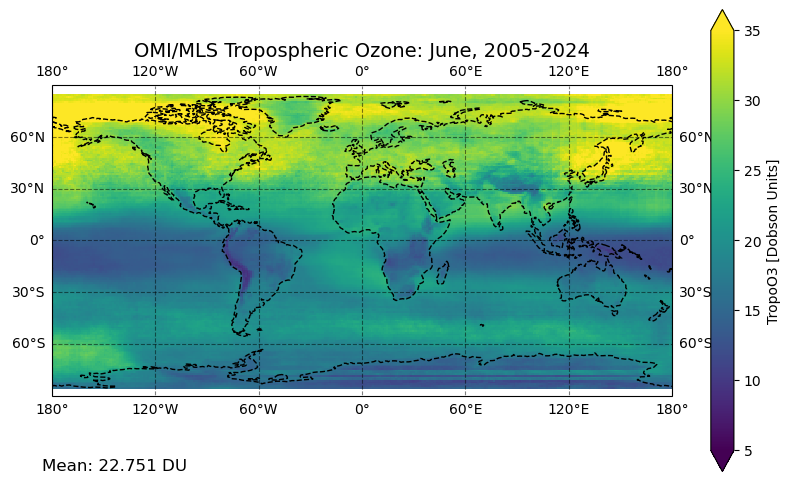

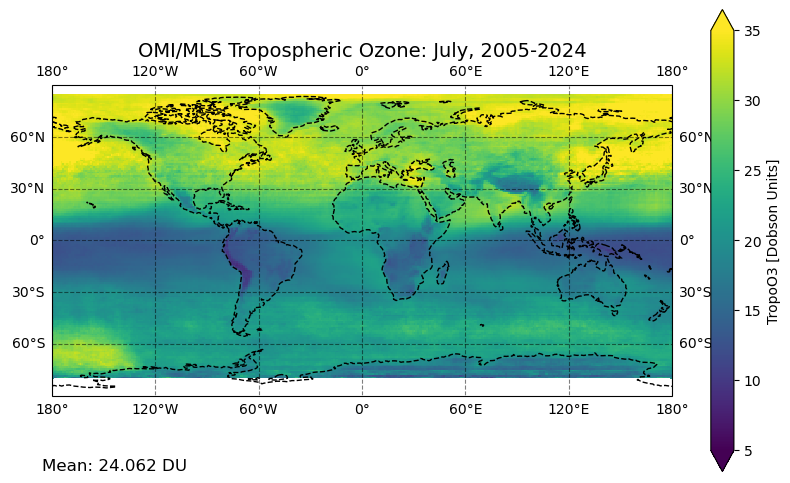

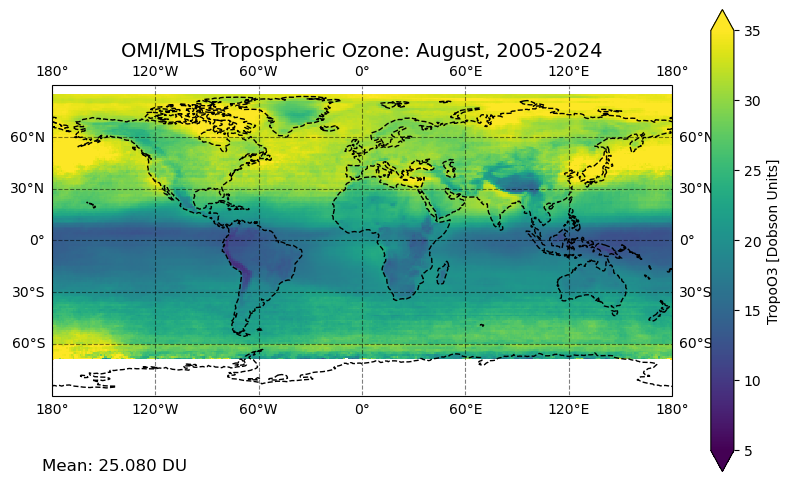

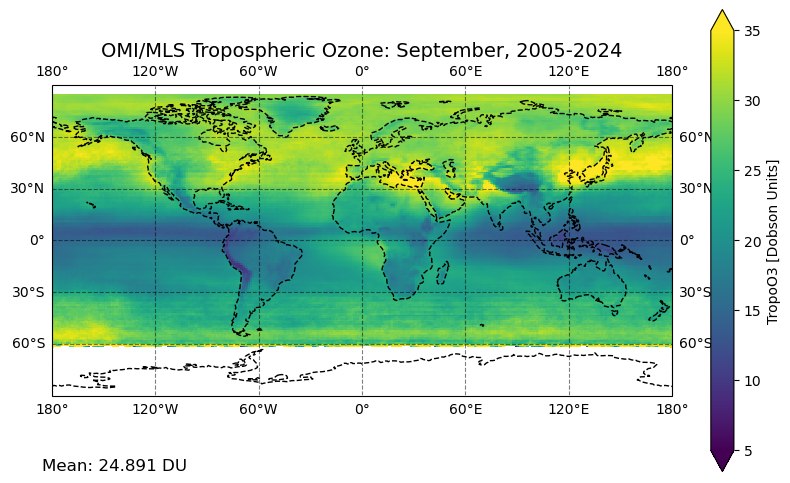

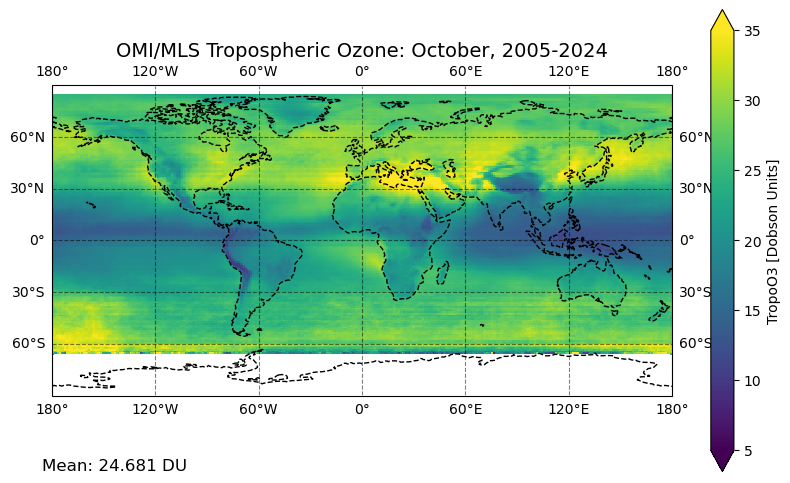

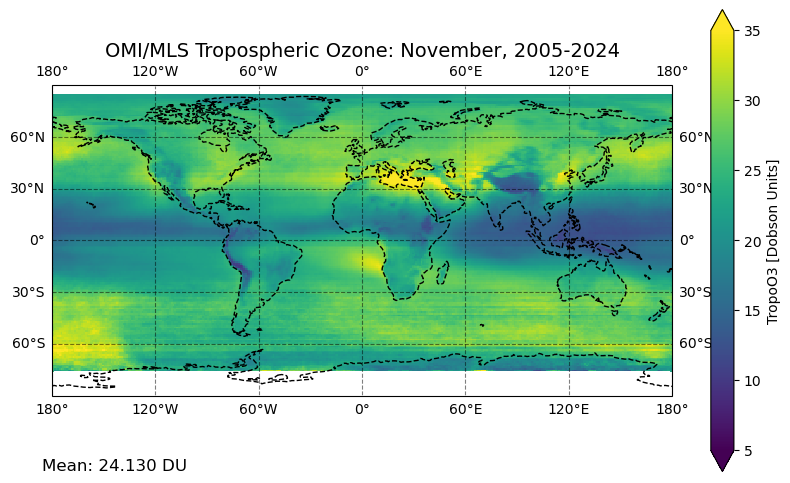

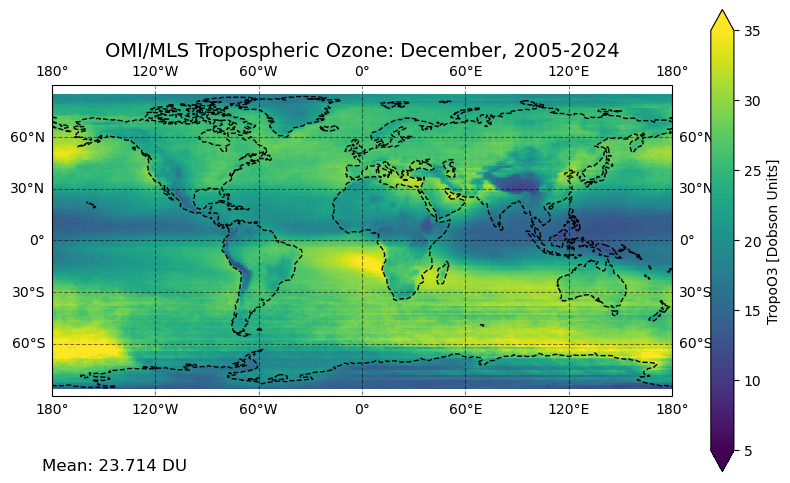

In [7]:
# plot the monthly means

lon_coords = np.arange(0.5, 360.5, 1)
lat_coords = np.arange(-89.5,90.5, 1)

monthly_mean = monthly_mean.assign_coords(
    longitude=('x_elements', lon_coords),
    latitude=('y_elements', lat_coords)
)

month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
              'September', 'October', 'November', 'December']
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']
i=0

for month in month_list:
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    monthly_mean[i].plot(ax=ax,transform=ccrs.PlateCarree(central_longitude=180), 
                         x='longitude', y='latitude', vmin=5, vmax=35, extend='both')
    ax.add_feature(cfeature.COASTLINE, linestyle='--')
    ax.set_global()

    # adding gridlines
    ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')

    ax.set_title('OMI/MLS Tropospheric Ozone: ' + str(month) + ', 2005-2024', fontsize=14)
    formatted_mean = f"{monthly_mean[i].mean().data:.3f}"

    ax.text(0.10, -0.25, 'Mean: ' + str(formatted_mean) + ' DU', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=12)

    plt.savefig("figures/Monthly_Mean_TropoO3-" + str(alphabet[i]))
    plt.show()
    i+=1

In [8]:
import imageio
import os

def create_gif(image_folder, output_gif, duration):
    filenames = sorted([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))])
    images = []
    for filename in filenames:
        if filename.startswith('Monthly_Mean'):
            image_path = os.path.join(image_folder, filename)
            images.append(imageio.imread(image_path))
    imageio.mimsave(output_gif, images, duration=duration)

image_dir = '/glade/u/home/mvoncyga/workspace/figures/'
gif_file = "TropoO3climatology.gif"


create_gif(image_dir, gif_file, duration=1000)

/glade/derecho/scratch/mvoncyga/tmp/ipykernel_114519/1654749537.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_path))


Standard Deviation Plots

In [9]:
monthly_stdev = ozone.groupby('time.month').std('months')

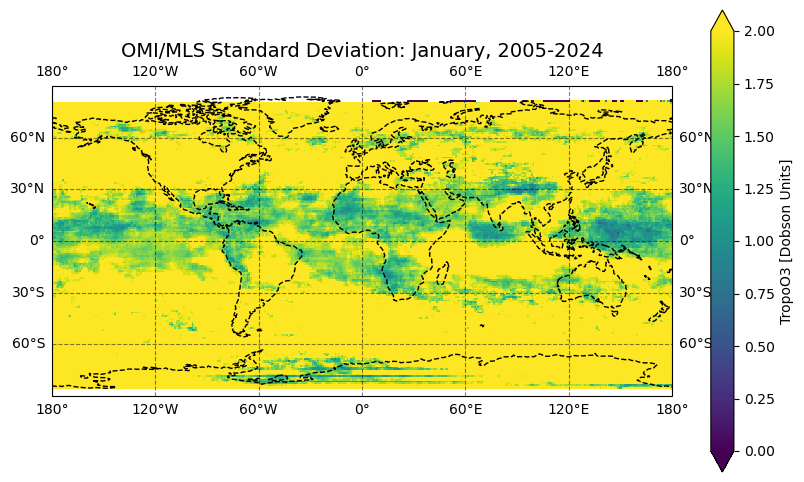

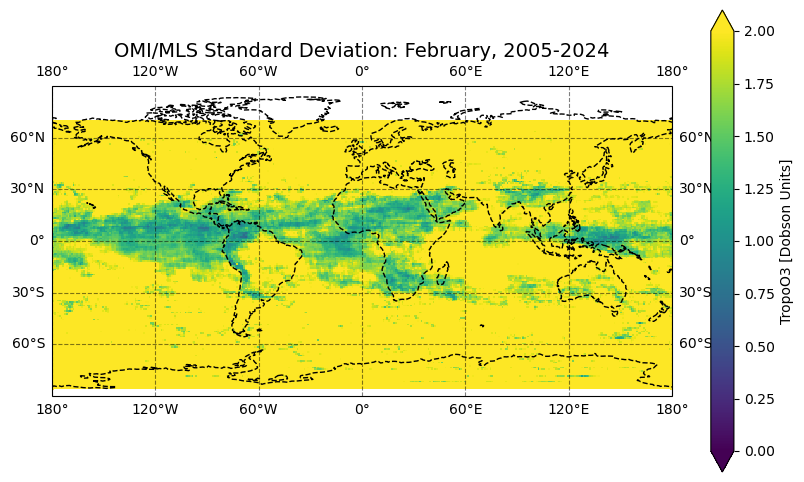

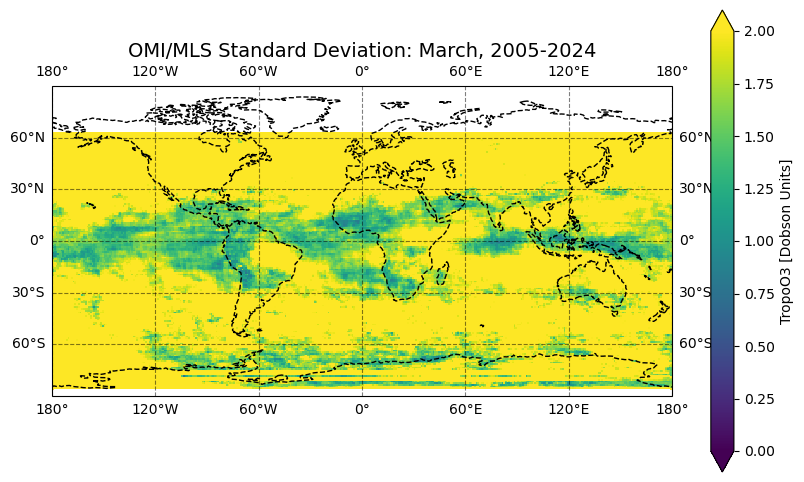

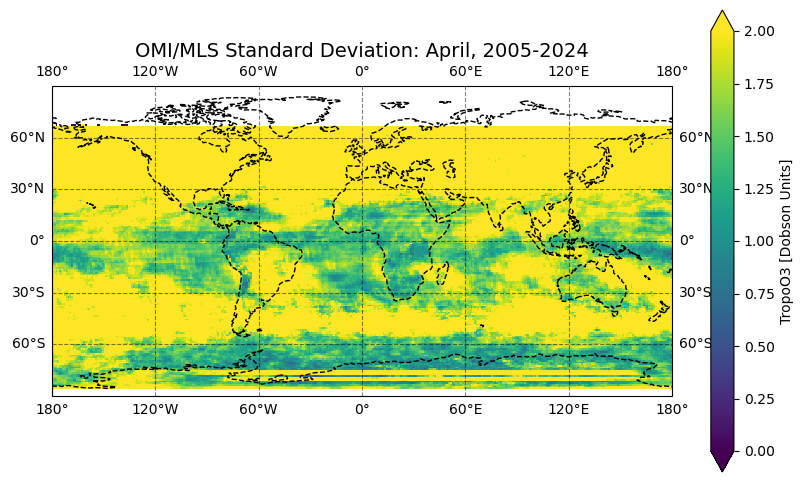

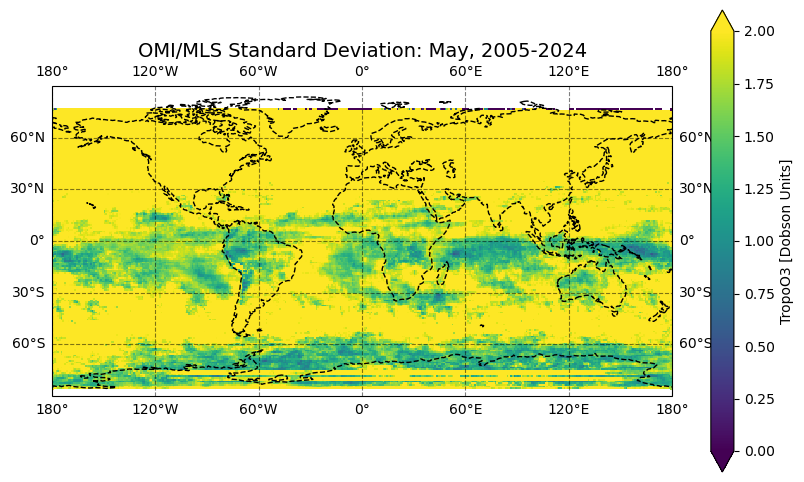

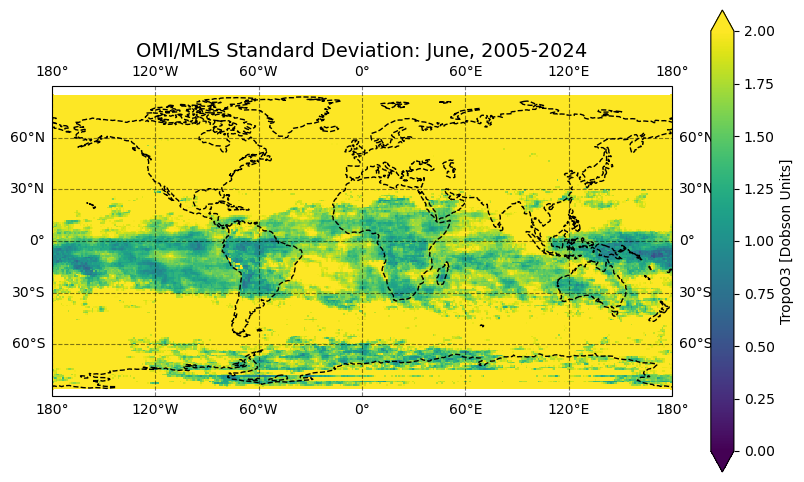

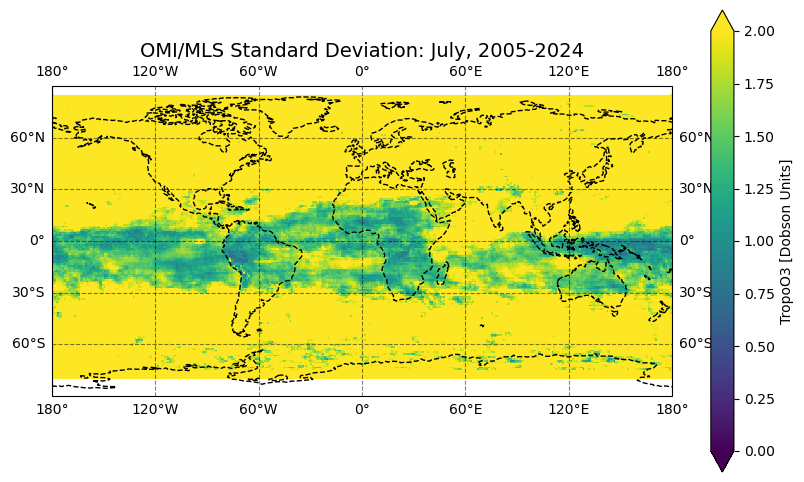

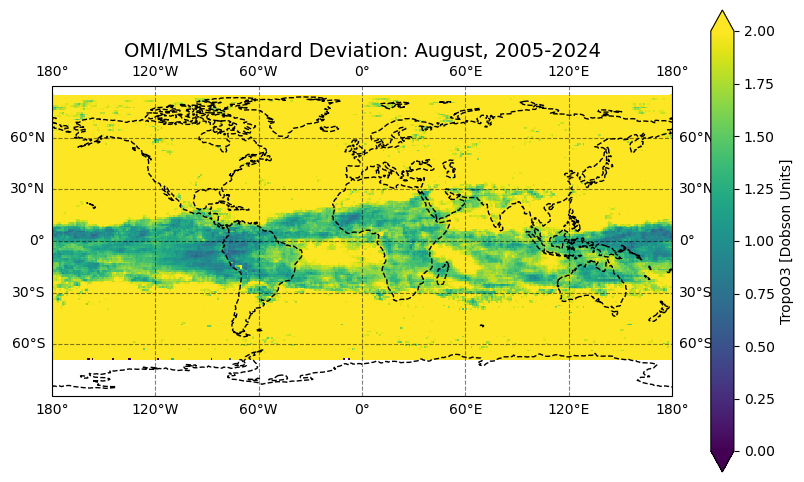

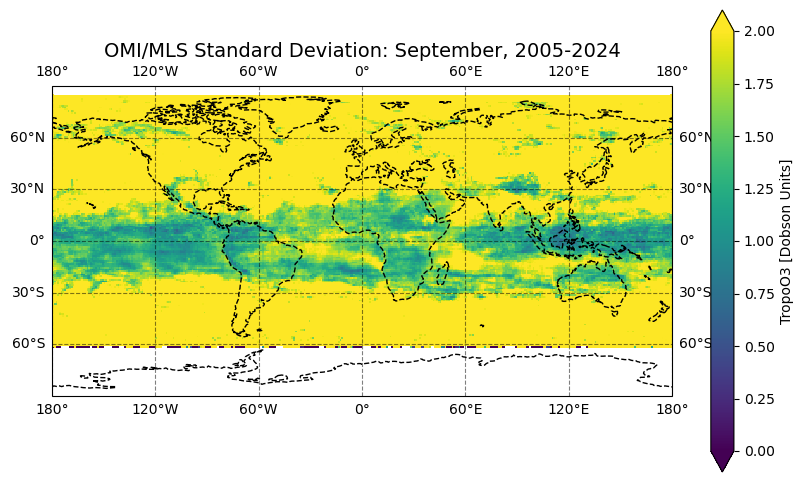

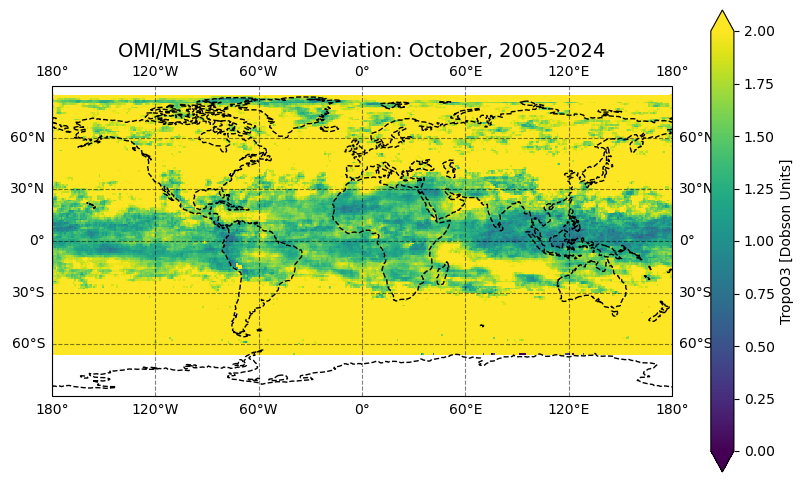

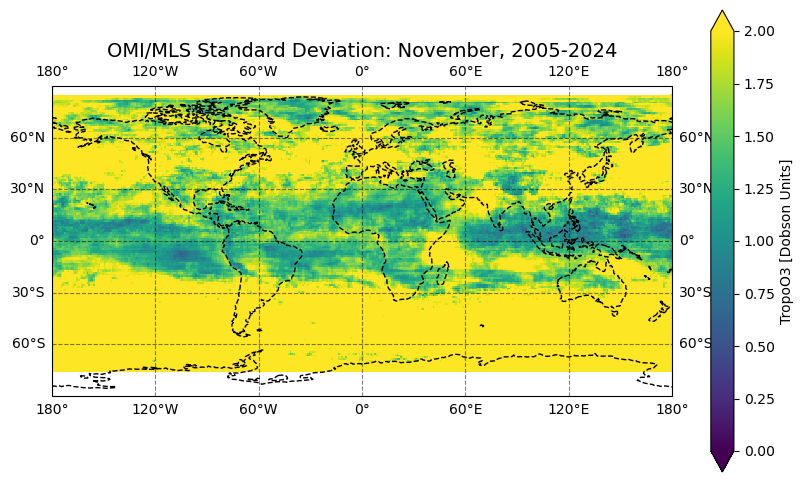

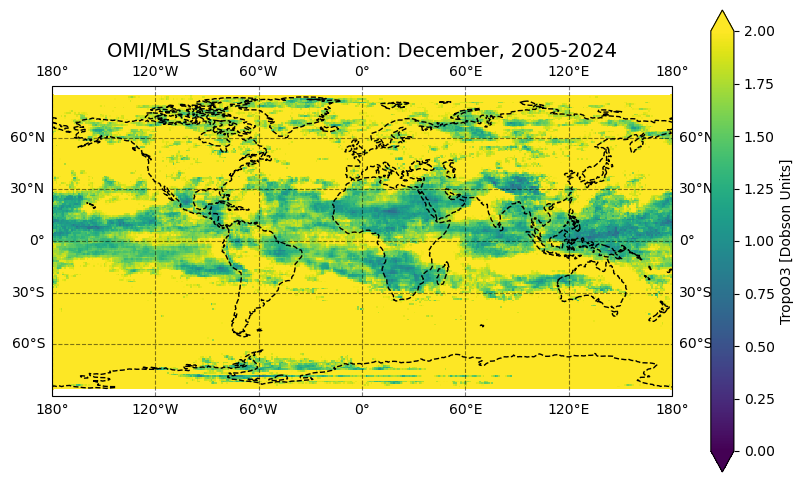

In [10]:
# plot the monthly means

lon_coords = np.arange(0.5, 360.5, 1)
lat_coords = np.arange(-89.5,90.5, 1)

monthly_stdev = monthly_stdev.assign_coords(
    longitude=('x_elements', lon_coords),
    latitude=('y_elements', lat_coords)
)

i=0
for month in month_list:
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    monthly_stdev[i].plot(ax=ax,transform=ccrs.PlateCarree(central_longitude=180), 
                         x='longitude', y='latitude', vmin=0, vmax=2, extend='both')
    ax.add_feature(cfeature.COASTLINE, linestyle='--')
    ax.set_global()

    # adding gridlines
    ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')

    ax.set_title('OMI/MLS Standard Deviation: ' + str(month) + ', 2005-2024', fontsize=14)

    plt.savefig("figures/Monthly_Standev_TropoO3-" + str(alphabet[i]))
    plt.show()
    i+=1

In [11]:
import imageio
import os

def create_gif(image_folder, output_gif, duration):
    filenames = sorted([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))])
    images = []
    for filename in filenames:
        if filename.startswith('Monthly_Standev'):
            image_path = os.path.join(image_folder, filename)
            images.append(imageio.imread(image_path))
    imageio.mimsave(output_gif, images, duration=duration)

image_dir = '/glade/u/home/mvoncyga/workspace/figures/'
gif_file = "TropoO3climatology_Standev.gif"

create_gif(image_dir, gif_file, duration=1000)

/glade/derecho/scratch/mvoncyga/tmp/ipykernel_114519/3487410766.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_path))


In [12]:
monthly_mean[2].mean()

<xarray.DataArray 'TropoO3' ()> Size: 8B
array(21.14493179)
Coordinates:
    month    int64 8B 3

In [13]:
monthly_mean.fillna(-999)
# turn all NaNs into -999

<xarray.DataArray 'TropoO3' (month: 12, y_elements: 180, x_elements: 360)> Size: 3MB
array([[[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
...
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]]], dtype=float32)
Coordinates:
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    longitude  (x_elements) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    latitude   (y_elements) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Dimensions without coordinates: y_elements, x_elements
Attributes:
    units:      Dobson Units
    name:       Tropo O3 Gnd-to-Tropopause
    latitude:   -89.5, -88.5, ..., 89.5
    longitude:  -179.5, -178.5, ..., 179.5
    Month:      Oct2004, Nov2004, ..., Dec2024

In [14]:
monthly_mean.to_netcdf(path="/glade/u/home/mvoncyga/workspace/monthly_mean_tco300hpa_omimls_2004_2024.nc",format="NETCDF4")